In [1]:
from pathlib import Path
import pandas as pd

# Ruta base
ruta_base = Path("../data/raw")

# Cargar todos los archivos de ventas históricas (incluyendo items si es necesario)
archivos_ventas = sorted(ruta_base.glob("ventas_dcto_items_*.xlsx"))
print(f"Se encontraron {len(archivos_ventas)} archivos de ventas históricas.")

# Unir en un único DataFrame
ventas_items = pd.concat([pd.read_excel(f, engine="openpyxl") for f in archivos_ventas], ignore_index=True)

# Verificar columnas disponibles
ventas_items.columns


Se encontraron 15 archivos de ventas históricas.


Index(['cod_cliente', 'cliente', 'documento', 'defecha',
       'cod_articulo_servicio', 'nombre_articulo_servicio', 'cantidad',
       'porc_iva', 'vrgravado', 'vrnogravado', 'descuento', 'subtotal',
       'costo', 'utilidadps', 'utilidadpc', 'tipodocumento', 'cuenta',
       'nomcuenta', 'icolicoresunitario', 'bodega', 'vendedor', 'distrito'],
      dtype='object')

In [2]:
# Convertir la columna 'defecha' a datetime
ventas_items['defecha'] = pd.to_datetime(ventas_items['defecha'])

# Crear la columna 'mes' en formato AAAA-MM
ventas_items['mes'] = ventas_items['defecha'].dt.to_period('M').astype(str)


In [3]:
#Agrupar ventas por canal y mes
# Agrupar ventas por canal (cuenta) y mes
ventas_canales = ventas_items.groupby(['mes', 'cuenta'])['cantidad'].sum().reset_index()

# Renombrar para claridad
ventas_canales.rename(columns={'cantidad': 'ventas_totales'}, inplace=True)

# Mostrar primeras filas para validar
ventas_canales.head()


,mes,cuenta,ventas_totales
0,2019-01,4175 95 25,-111.875
1,2019-01,4175 95 39,-667.630
2,2019-02,4175 95 25,-95.920
3,2019-02,4175 95 39,-4225.225
4,2019-03,4175 95 25,-176.700


In [4]:
df_cuentas = pd.read_excel("../data/raw/clientes.xlsx")


In [5]:
df_cuentas.columns


Index(['codigo', 'razon social', 'direccion', 'nombre ciudad', 'cod ciudad',
       'cupo', 'plazo', 'telefonos', 'contactos', 'telefonos.1', 'telefonos.2',
       'email', 'vendedor', 'nit', 'dv', 'distrito', 'pais'],
      dtype='object')

In [6]:
# Renombrar columna 'codigo' de df_cuentas a 'cuenta' para hacer el merge
df_cuentas_renombrado = df_cuentas.rename(columns={'codigo': 'cuenta'})

# Hacer merge para agregar información del canal
ventas_canales = ventas_canales.merge(
    df_cuentas_renombrado[['cuenta', 'razon social']],  # puedes agregar más columnas si quieres
    on='cuenta',
    how='left'
)

# Reorganizar columnas para claridad
ventas_canales = ventas_canales[['mes', 'cuenta', 'razon social', 'ventas_totales']]


In [7]:
# Filtrar canales con ventas negativas
ventas_negativas = ventas_canales[ventas_canales['ventas_totales'] < 0]


In [8]:
# Agregar columnas vacías para validación manual
ventas_canales['Validar Canal'] = ''
ventas_canales['Requiere Revisión'] = ''
ventas_canales['Observaciones'] = ''
ventas_canales['Acciones Sugeridas'] = ''
ventas_canales['Notas de Apoyo'] = ''



In [9]:
ventas_canales = ventas_canales[[
    'mes', 'cuenta', 'razon social', 'ventas_totales',
    'Validar Canal', 'Requiere Revisión', 'Observaciones',
    'Acciones Sugeridas', 'Notas de Apoyo'
]]


In [10]:
# Ver cuántos registros hay con ventas_totales positivas
ventas_canales[ventas_canales['ventas_totales'] > 0].shape


(463, 9)

In [11]:
ventas_canales['ventas_totales'] = pd.to_numeric(ventas_canales['ventas_totales'], errors='coerce')


In [12]:
print(ventas_canales.columns)


Index(['mes', 'cuenta', 'razon social', 'ventas_totales', 'Validar Canal',
       'Requiere Revisión', 'Observaciones', 'Acciones Sugeridas',
       'Notas de Apoyo'],
      dtype='object')


In [13]:
ventas_validas = ventas_canales[ventas_canales['ventas_totales'].notna() & (ventas_canales['ventas_totales'] > 0)]



In [14]:
print(ventas_canales['cuenta'].dtype)
print(df_cuentas_renombrado['cuenta'].dtype)




object
object


In [15]:
# Eliminar espacios y convertir todo a texto plano y limpio
ventas_canales['cuenta'] = ventas_canales['cuenta'].str.strip()
df_cuentas_renombrado['cuenta'] = df_cuentas_renombrado['cuenta'].astype(str).str.strip()


In [16]:
ventas_canales = ventas_canales.merge(
    df_cuentas_renombrado[['cuenta', 'razon social']],
    on='cuenta',
    how='left'
)


In [17]:
print(ventas_canales.columns.tolist())



['mes', 'cuenta', 'razon social_x', 'ventas_totales', 'Validar Canal', 'Requiere Revisión', 'Observaciones', 'Acciones Sugeridas', 'Notas de Apoyo', 'razon social_y']


In [18]:
ventas_canales.rename(columns={'razon social_y': 'razon social'}, inplace=True)


In [19]:
ventas_canales[['cuenta', 'razon social']].drop_duplicates().head(10)


,cuenta,razon social
0,4175 95 25,NaN
1,4175 95 39,NaN
8,4175 95 20,NaN
40,4175 97 01,NaN
53,4175 98 01,NaN
73,4175 97 19,NaN
101,2408 52 20,NaN
102,4135 95 5,NaN
103,4135 95 10,NaN
104,4135 95 15,NaN


In [20]:
print(ventas_canales['cuenta'].drop_duplicates().sort_values().head(10))
print(df_cuentas_renombrado['cuenta'].drop_duplicates().sort_values().head(10))


101    2408 52 20
102    4135 95  5
103    4135 95 10
104    4135 95 15
105    4135 95 19
106    4135 95 25
107    4135 95 30
108    4135 95 39
109    4135 95 60
110    4135 95 65
Name: cuenta, dtype: object
5053    CL  100000000001
684     CL  100000000002
5234    CL  100000000003
3835    CL  100000000004
3989    CL  100000000005
5218    CL  100000000006
169     CL  100000000007
249     CL  100000000008
2327    CL  100000000009
3100    CL  100000000010
Name: cuenta, dtype: object


In [21]:
print(ventas_items.columns)
print(df_cuentas.columns)


Index(['cod_cliente', 'cliente', 'documento', 'defecha',
       'cod_articulo_servicio', 'nombre_articulo_servicio', 'cantidad',
       'porc_iva', 'vrgravado', 'vrnogravado', 'descuento', 'subtotal',
       'costo', 'utilidadps', 'utilidadpc', 'tipodocumento', 'cuenta',
       'nomcuenta', 'icolicoresunitario', 'bodega', 'vendedor', 'distrito',
       'mes'],
      dtype='object')
Index(['codigo', 'razon social', 'direccion', 'nombre ciudad', 'cod ciudad',
       'cupo', 'plazo', 'telefonos', 'contactos', 'telefonos.1', 'telefonos.2',
       'email', 'vendedor', 'nit', 'dv', 'distrito', 'pais'],
      dtype='object')


In [22]:
print(ventas_items['cod_cliente'].dtype)
print(df_cuentas['codigo'].dtype)


object
object


In [23]:
print(ventas_items['cod_cliente'].drop_duplicates().sort_values().head(10))
print(df_cuentas['codigo'].drop_duplicates().sort_values().head(10))


321               CL 10001
485               CL 10003
360               CL 10023
1825              CL 10024
344415            CL 10028
340007            CL 10031
529805            CL 10034
747               CL 10038
3384              CL 10039
289176            CL 10062
Name: cod_cliente, dtype: object
642             CL 10001
2465            CL 10002
400             CL 10003
1771            CL 10004
984             CL 10005
1138            CL 10006
601             CL 10007
768             CL 10008
209             CL 10009
3844            CL 10010
Name: codigo, dtype: object


In [24]:
# Buscar si hay espacios adelante o atrás
print(ventas_items['cod_cliente'].astype(str).str.strip().equals(ventas_items['cod_cliente'].astype(str)))

print(df_cuentas['codigo'].astype(str).str.strip().equals(df_cuentas['codigo'].astype(str)))


False
False


In [25]:
print(ventas_items['cod_cliente'].isna().sum())
print(df_cuentas['codigo'].isna().sum())


469705
0


In [26]:
ventas_items_filtrado = ventas_items[ventas_items['cod_cliente'].notna()]


In [27]:
ventas_items_filtrado['cod_cliente'] = ventas_items_filtrado['cod_cliente'].astype(str).str.strip()
df_cuentas['codigo'] = df_cuentas['codigo'].astype(str).str.strip()


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_10836/2659117234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventas_items_filtrado['cod_cliente'] = ventas_items_filtrado['cod_cliente'].astype(str).str.strip()


In [28]:
ventas_con_info_cliente = ventas_items_filtrado.merge(
    df_cuentas[['codigo', 'razon social']],
    left_on='cod_cliente',
    right_on='codigo',
    how='left'
)


In [29]:
ventas_con_info_cliente['razon social'].isna().sum()


0

In [30]:
ventas_con_info_cliente.head(10)


,cod_cliente,cliente,documento,defecha,cod_articulo_servicio,nombre_articulo_servicio,cantidad,porc_iva,vrgravado,vrnogravado,...,tipodocumento,cuenta,nomcuenta,icolicoresunitario,bodega,vendedor,distrito,mes,codigo,razon social
0,CL 100000001179,CORTES GARZON BLANCA JAZMIN,1 8262,2019-01-10,120692,MAESE 6 MESES X 150 GRS,-2.000,19,-22689.0,0.0,...,D.COMER,4175 95 39,DEVOLUCION EN VENTAS COMERCIAL AL 19%,0,1.0,ALVARADO CARLOS,NaN,2019-01,CL 100000001179,CORTES GARZON BLANCA JAZMIN
1,CL 100000000398,CENCOSUD COLOMBIA S.A.,1 8266,2019-01-15,156083,COLBY JACK X 3 KL APROX,-0.430,0,0.0,-26698.0,...,D.COMER,4175 95 25,DEVOLUCIONES NO GRAVADAS COMERCIAL,0,1.0,BODEGA PRINCIPAL,NaN,2019-01,CL 100000000398,CENCOSUD COLOMBIA S.A.
2,CL 100000000398,CENCOSUD COLOMBIA S.A.,1 8266,2019-01-15,156079,MUENSTER X KL,-0.345,0,0.0,-14383.0,...,D.COMER,4175 95 25,DEVOLUCIONES NO GRAVADAS COMERCIAL,0,1.0,BODEGA PRINCIPAL,NaN,2019-01,CL 100000000398,CENCOSUD COLOMBIA S.A.
3,CL 100000000398,CENCOSUD COLOMBIA S.A.,1 8266,2019-01-15,156077,MILD CHEDDARx X KL,-0.290,19,-18119.0,0.0,...,D.COMER,4175 95 39,DEVOLUCION EN VENTAS COMERCIAL AL 19%,0,1.0,BODEGA PRINCIPAL,NaN,2019-01,CL 100000000398,CENCOSUD COLOMBIA S.A.
4,CL 100000000398,CENCOSUD COLOMBIA S.A.,1 8267,2019-01-15,156050,RICOTTA REGULARx15oz,-3.000,0,0.0,-36465.0,...,D.COMER,4175 95 25,DEVOLUCIONES NO GRAVADAS COMERCIAL,0,1.0,BODEGA PRINCIPAL,NaN,2019-01,CL 100000000398,CENCOSUD COLOMBIA S.A.
5,CL 10691,LA RESERVA VINOS Y LICORES S.A.S.,1 8263,2019-01-16,170011,ARLA CAMEMBERT ROSENBOGR X 125 GR,-92.000,19,-850420.0,0.0,...,D.COMER,4175 95 39,DEVOLUCION EN VENTAS COMERCIAL AL 19%,0,1.0,ALZATE ELENA,NaN,2019-01,CL 10691,LA RESERVA VINOS Y LICORES S.A.S.
6,CL 100000000821,ECHEVERRI OQUENDO MONICA MARCELA,1 8264,2019-01-17,121222,ALMOND BREEZE L.V. UNSWEETENED VAIINILLA X 946,-24.000,19,-254118.0,0.0,...,D.COMER,4175 95 39,DEVOLUCION EN VENTAS COMERCIAL AL 19%,0,1.0,PELAEZ PARRA CLAUDIA,NaN,2019-01,CL 100000000821,ECHEVERRI OQUENDO MONICA MARCELA
7,CL 100000000168,MORANGO S. A. S.,1 8265,2019-01-21,121038,HOL GOUDA BARRA GRAND X3.1 X KL,-0.320,19,-8040.0,0.0,...,D.COMER,4175 95 39,DEVOLUCION EN VENTAS COMERCIAL AL 19%,0,1.0,ALZATE ELENA,NaN,2019-01,CL 100000000168,MORANGO S. A. S.
8,CL 100000000398,CENCOSUD COLOMBIA S.A.,1 8274,2019-01-22,121011,TOMATES AL GRANEL PYMx X KL,-4.500,19,-296505.0,0.0,...,D.COMER,4175 95 39,DEVOLUCION EN VENTAS COMERCIAL AL 19%,0,1.0,BODEGA PRINCIPAL,NaN,2019-01,CL 100000000398,CENCOSUD COLOMBIA S.A.
9,CL 100000000398,CENCOSUD COLOMBIA S.A.,1 8275,2019-01-22,156050,RICOTTA REGULARx15oz,-12.000,0,0.0,-145860.0,...,D.COMER,4175 95 25,DEVOLUCIONES NO GRAVADAS COMERCIAL,0,1.0,BODEGA PRINCIPAL,NaN,2019-01,CL 100000000398,CENCOSUD COLOMBIA S.A.


In [31]:
ventas_con_info_cliente[['cod_cliente', 'razon social']].drop_duplicates().head(10)


,cod_cliente,razon social
0,CL 100000001179,CORTES GARZON BLANCA JAZMIN
1,CL 100000000398,CENCOSUD COLOMBIA S.A.
5,CL 10691,LA RESERVA VINOS Y LICORES S.A.S.
6,CL 100000000821,ECHEVERRI OQUENDO MONICA MARCELA
7,CL 100000000168,MORANGO S. A. S.
10,CL 100000000798,COMERCIALIZADORA MERCALDAS S.A
12,CL 100000001144,LAURELES S.A.S
14,CL 100000000502,NEGOCIOS LA PLAZA SAS
20,CL 100000001177,FIDEICOMISO G H BOGOTA - FIDUBOGOTA
21,CL 100000000260,ADMINISTRADORA MONSERRATE S.A.S


In [32]:
ventas_con_info_cliente.groupby(['cod_cliente', 'razon social'])['cantidad'].sum().sort_values(ascending=False).head(10)


cod_cliente       razon social                     
CL  100000000398  CENCOSUD COLOMBIA S.A.               570605.808
CL 10003          ALMACENES EXITO S A                  265292.000
CL  100000001067  SUPERTIENDAS CAÑAVERAL SAS            96532.091
CL 10451          INVERSIONES EURO S. A.                72296.848
CL  100000000502  NEGOCIOS LA PLAZA SAS                 39973.570
CL  100000001602  FARMATODO COLOMBIA S.A.               38088.000
CL 10292          SUPER A LIMITADA                      33703.757
CL 10351          DLK S.A.S.                            32076.916
CL  100000001136  ADWELLCH S.A.S.                       31935.000
CL  100000000055  GODDARD CATERING GROUP BOGOTA SAS     28914.700
Name: cantidad, dtype: float64

In [33]:
ventas_por_cliente = ventas_con_info_cliente.groupby(
    ['cod_cliente', 'razon social']
)['cantidad'].sum().reset_index()
ventas_por_cliente.rename(columns={'cantidad': 'ventas_totales'}, inplace=True)


In [34]:
ventas_por_cliente['Validar Canal'] = ''
ventas_por_cliente['Requiere Revisión'] = ''
ventas_por_cliente['Observaciones'] = ''
ventas_por_cliente['Acciones Sugeridas'] = ''
ventas_por_cliente['Notas de Apoyo'] = ''


In [35]:
columnas_ordenadas = [
    'cod_cliente', 'razon social', 'ventas_totales',
    'Validar Canal', 'Requiere Revisión',
    'Observaciones', 'Acciones Sugeridas', 'Notas de Apoyo'
]
ventas_para_exportar = ventas_por_cliente[columnas_ordenadas]


In [36]:
# Agrupar por cliente y sumar cantidad y valor
ventas_por_cliente = ventas_con_info_cliente.groupby(
    ['cod_cliente', 'razon social']
)[['cantidad', 'subtotal']].sum().reset_index()

# Renombrar columnas para claridad
ventas_por_cliente.rename(columns={
    'cantidad': 'ventas_totales_unidades',
    'subtotal': 'ventas_totales_valor'
}, inplace=True)

ventas_por_cliente = ventas_por_cliente[ventas_por_cliente['ventas_totales_unidades'] > 0]

# Calcular ticket promedio (sin división por cero)
ventas_por_cliente['ticket_promedio'] = (
    ventas_por_cliente['ventas_totales_valor'] / ventas_por_cliente['ventas_totales_unidades']
)



In [37]:
# Ver resumen estadístico
print(ventas_por_cliente['ticket_promedio'].describe())


count    6.130000e+02
mean     8.582491e+05
std      1.144976e+07
min     -2.744876e+04
25%      1.420680e+04
50%      1.662774e+04
75%      2.550972e+04
max      2.300000e+08
Name: ticket_promedio, dtype: float64


In [38]:
#Usar categorizacion de K-means para analisis del comportamiento
from sklearn.cluster import KMeans
import numpy as np

# Crear matriz de valores
X = ventas_por_cliente[['ticket_promedio']].values

# Aplicar K-Means con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
ventas_por_cliente['cluster'] = kmeans.fit_predict(X)

# Ordenar los clusters según valor promedio para asignar etiquetas
cluster_centers = kmeans.cluster_centers_.flatten()
sorted_clusters = np.argsort(cluster_centers)

# Crear etiquetas ordenadas
etiquetas = ['Muy Bajo', 'Bajo', 'Medio', 'Alto']
cluster_labels = dict(zip(sorted_clusters, etiquetas))
ventas_por_cliente['categoria_cliente'] = ventas_por_cliente['cluster'].map(cluster_labels)


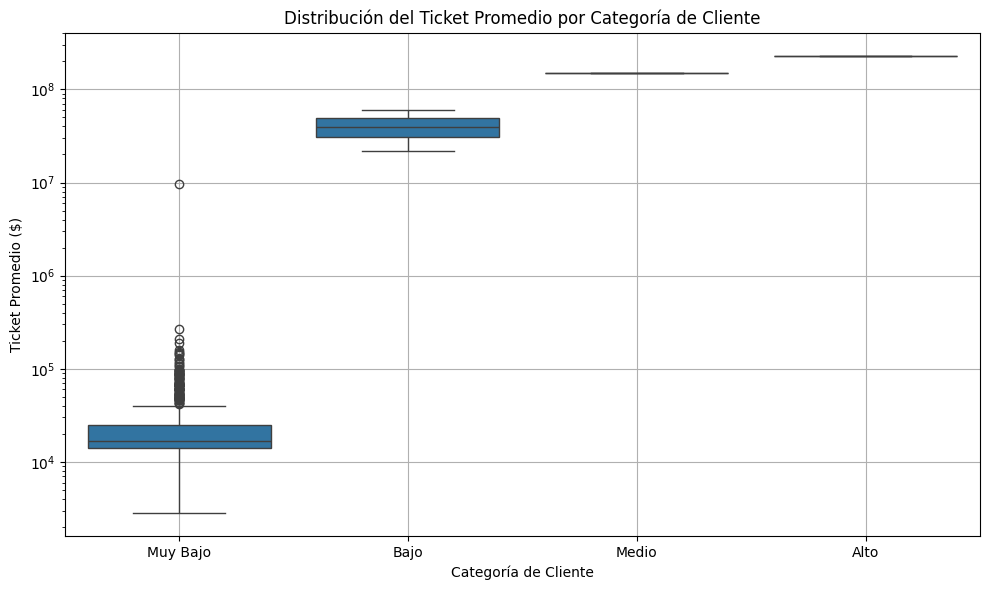

In [39]:
#Grafico de distribucion de ticket promedio por categoria
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=ventas_por_cliente, x='categoria_cliente', y='ticket_promedio', order=['Muy Bajo', 'Bajo', 'Medio', 'Alto'])
plt.title('Distribución del Ticket Promedio por Categoría de Cliente')
plt.xlabel('Categoría de Cliente')
plt.ylabel('Ticket Promedio ($)')
plt.yscale('log')  # Útil si hay mucha dispersión
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
#Tabla de resumen por categoria
resumen_categoria = ventas_por_cliente.groupby('categoria_cliente').agg(
    clientes=('cod_cliente', 'count'),
    ticket_promedio_medio=('ticket_promedio', 'mean'),
    ventas_totales=('ventas_totales_valor', 'sum')
).reset_index()

display(resumen_categoria)


,categoria_cliente,clientes,ticket_promedio_medio,ventas_totales
0,Alto,1,2.300000e+08,2.300000e+08
1,Bajo,3,4.055433e+07,1.216630e+08
2,Medio,1,1.484220e+08,1.484220e+08
3,Muy Bajo,608,4.279886e+04,4.131354e+10


In [41]:
#Exportacion de los archivos de tickets promedios 
output_path = "../outputs/reports/clientes_ticket_promedio_kmeans.xlsx"
ventas_por_cliente.to_excel(output_path, index=False)


In [42]:
print(ventas_por_cliente['categoria_cliente'].value_counts())


categoria_cliente
Muy Bajo    608
Bajo          3
Alto          1
Medio         1
Name: count, dtype: int64


In [48]:
ventas_por_cliente.columns.tolist()


['cod_cliente',
 'razon social',
 'ventas_totales_unidades',
 'ventas_totales_valor',
 'ticket_promedio',
 'cluster',
 'categoria_cliente',
 'validacion_potencia',
 'promedio_dias_entre_compras_x',
 'promedio_dias_entre_compras_y',
 'promedio_dias_entre_compras']

In [ ]:
# Eliminar columnas duplicadas antes del merge
columnas_a_borrar = [col for col in ventas_por_cliente.columns if 'promedio_dias_entre_compras' in col]

ventas_por_cliente = ventas_por_cliente.drop(columns=columnas_a_borrar)

# Realizacion el merge de categorias por clientes.
ventas_por_cliente = ventas_por_cliente.merge(promedio_dias_entre_compras, on='cod_cliente', how='left')

# Visualizar los primeros registros (Primeros 10 registros asociados a clientes)
ventas_por_cliente[['cod_cliente', 'razon social', 'promedio_dias_entre_compras']].head(10)





,cod_cliente,razon social,promedio_dias_entre_compras
0,CL 100000000011,MUÑOZ MEDINA NANCY,19.523077
1,CL 100000000033,TAKAMI SA,19.787234
2,CL 100000000055,GODDARD CATERING GROUP BOGOTA SAS,5.473171
3,CL 100000000064,VARGAS TORO JAIME FELIPE,60.125000
4,CL 100000000075,KATA S A S,9.397436
5,CL 100000000087,D Y D INVERSIONES S.A.S,9.443478
6,CL 100000000090,ABEL Y SOFIA SAS,6.266272
7,CL 100000000098,MULTISERVICIOS OP EMPRESA UNIPERSONAL,7.740088
8,CL 100000000100,MERCADER DEL VINO SAS,6.910891
9,CL 100000000113,BIOPLAZA SOCIEDAD POR ACCIONES SIMPLIFICADA,30.928571


In [69]:
output_path = "../outputs/reports/clientes_ticket_promedio_kmeans.xlsx"
ventas_por_cliente.to_excel(output_path, index=False)
